# PyTorch: IBA (Per-Sample Bottleneck)

This notebook shows how to apply the Per-Sample Bottleneck to pretrained ImageNet models. 

Ensure that `./imagenet` points to your copy of the ImageNet dataset. 

You might want to create a symlink:

In [8]:
! ln -s /home/yang/MLMI_InfoBottleneck/ imagenet 

ln: 无法创建符号链接'imagenet': 文件已存在


In [1]:
# to set you cuda device
%env CUDA_VISIBLE_DEVICES=0

%load_ext autoreload
%autoreload 2

import torch
import torchvision.models 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Normalize
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm_notebook
import json
from PIL import Image
import numpy as np
import sys

try:
    import IBA
except ModuleNotFoundError:
    sys.path.insert(0, '..')
    import IBA
    
from IBA.pytorch import IBA, tensor_to_np_img
from IBA.utils import plot_saliency_map

env: CUDA_VISIBLE_DEVICES=0


## Loading Data and Model

### Insert the bottleneck into the model

You can experiment with the location of the bottleneck.

In [2]:
imagenet_dir = '/home/yang/MLMI_InfoBottleneck/imagenet'

dev = torch.device('cpu:0')

# select a model to analyse
# model = torchvision.models.vgg16(pretrained=True)
model = torchvision.models.resnet50(pretrained=True)
# model = torchvision.models.inception_v3(pretrained=True)
model.to(dev).eval()

# load the data
if type(model) == torchvision.models.inception.Inception3:
    image_size = 299
else:
    image_size = 224
    
valset = ImageFolder(
    os.path.join(imagenet_dir, 'validation'),
    transform=Compose([
        CenterCrop(256), Resize(image_size), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

trainset = ImageFolder(
    os.path.join(imagenet_dir, 'train'),
    transform=Compose([
        CenterCrop(256), Resize(image_size), ToTensor(), 
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]))

with open('imagenet_class_index.json') as f:
    idx2class = {int(k): v[1] for k, v in json.load(f).items()}

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
img, target = valset[0]

In [3]:
if type(model) == torchvision.models.vgg.VGG:
    iba = IBA(model.features[17])
elif type(model) == torchvision.models.resnet.ResNet:
    iba = IBA(model.layer2)
elif type(model) == torchvision.models.inception.Inception3:
    iba = IBA(model.Mixed_5b)

In [4]:
iba.reset_estimate()

## Estimate Mean and Variance

Here, we estimate the mean and variances of the feature map. It is important for measuring the amount of information transmitted.

In [5]:
iba.estimate(model, trainloader, device=dev, n_samples=1000, progbar=True)

In [6]:
neuron = (12, 3, 4)
print("Neuron at position {:} has mean {:.2f} and std {:.2f}".format(
    neuron, iba.estimator.mean()[neuron],  iba.estimator.std()[neuron]))

Neuron at position (12, 3, 4) has mean 0.12 and std 0.13


In [7]:
iba.estimator.n_samples()

1024

## Display Heatmaps for some random samples



In [8]:
%matplotlib inline

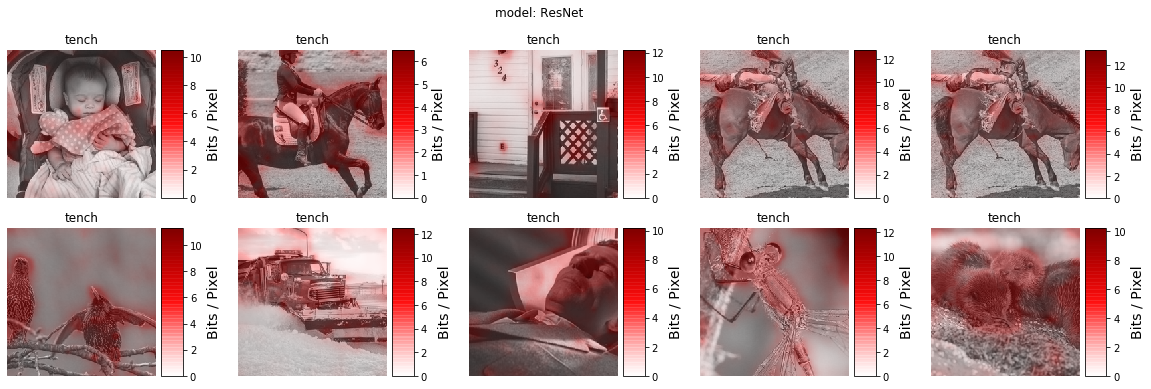

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
np.random.seed(0)
for ax, sample_idx in zip(axes.flatten(), np.random.choice(100, 10)):
    img, target = trainset[sample_idx]
    img = img[None].to(dev)
    
    # execute the model on a given sample and return the target NLL
    model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
    
    # generate the heatmap
    heatmap = iba.analyze(img, model_loss_closure)
    
    # reverse the data pre-processing for plotting the original image
    np_img = tensor_to_np_img(img[0])
    
    # show the heatmap
    plot_saliency_map(heatmap, np_img,  ax=ax)
    ax.set_title(idx2class[target])
    
fig.suptitle("model: {}".format(type(model).__name__))
plt.show()

## Monkey image

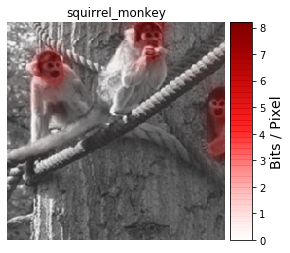

In [11]:
img = np.array(Image.open("./monkeys.jpg"))
img = (img.transpose(2, 0, 1) / 255)
target = 382  # 382: squirrel monkey

# preprocess image
img  = Compose([
    Resize(image_size), ToTensor(),  
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])(Image.open("./monkeys.jpg"))

model_loss_closure = lambda x: -torch.log_softmax(model(x), 1)[:, target].mean()
heatmap = iba.analyze(img[None].to(dev), model_loss_closure) 
ax = plot_saliency_map(heatmap, tensor_to_np_img(img))
_ = ax.set_title(idx2class[target])
plt.show()